# Setup Python Environment
The next cell sets up the dependencies in required for the notebook, run it.

In [1]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.10.0-rc1
print("done")

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
done


# Train Neural Network
## Parse and prepare the data
The next cell parses the csv files and transforms them to a format that will be used to train the full connected neural network.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import fileinput
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Ftrl

import time

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run

2023-02-16 12:30:39.686817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 12:30:39.752218: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-16 12:30:39.771264: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-16 12:30:40.144915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

TensorFlow version = 2.10.0-rc1



In [3]:
# SEED = 1337
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

# SEED=int(time.time())
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

CLASSES = [];

for file in os.listdir("../data/own-csv"):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])

CLASSES.sort()

print(CLASSES)

['laptop', 'phone_charging', 'school_box', 'school_pc', 'school_printer']


In [4]:
SAMPLES_WINDOW_LEN = 1
NUM_CLASSES = len(CLASSES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

# read each csv file and push an input and output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv("../data/own-csv/" + objectClass + ".csv") #, parse_dates=['timestamp']
  df = df.drop(columns=['time'])
  df = df.drop(columns=['Voltage'])
  columns = list(df)
  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)

  # calculate the number of objectClass recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_WINDOW_LEN)
  print(f"\u001b[32;4m{objectClass}\u001b[0m class will be output \u001b[32m{class_index}\u001b[0m of the classifier")
  print(f"{num_recordings} samples captured for training with inputs {list(df)} \n")
  
  #tensors
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  for i in range(num_recordings):
    tensor = []
    row = []
    for c in columns:
      row.append(df[c][i])
    tensor += row
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)
num_inputs_2 = len(inputs)
print(CLASSES)
print(inputs)
print(outputs)
print(num_inputs_2)

# print("Data set parsing and preparation complete.")
# startTimestamp = df['timestamp'].iloc[0]
# endTimestamp = df['timestamp'].iloc[-1]
# print(endTimestamp - startTimestamp)


laptop class will be output 0 of the classifier
119 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

phone_charging class will be output 1 of the classifier
209 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

school_box class will be output 2 of the classifier
124 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

school_pc class will be output 3 of the classifier
123 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

school_printer class will be output 4 of the classifier
119 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

['laptop', 'phone_charging', 'school_box', 'school_pc', 'school_printer']
[[55.     0.25   0.93  51.    20.   ]
 [52.     0.239  1.    52.     0.   ]
 [54.     0.247  0.96 

In [5]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")
print(inputs_test)
print(num_inputs)

Data set randomization and splitting complete.
[[1.80e+01 8.30e-02 4.00e-02 1.00e+00 1.80e+01]
 [2.70e+01 1.22e-01 8.20e-01 2.20e+01 1.50e+01]
 [7.10e+01 3.31e-01 1.00e+00 7.10e+01 0.00e+00]
 [1.70e+01 8.00e-02 5.00e-02 1.00e+00 1.70e+01]
 [2.40e+01 1.11e-01 6.00e-01 1.50e+01 1.90e+01]
 [2.50e+01 1.13e-01 5.70e-01 1.40e+01 2.00e+01]
 [1.20e+01 5.50e-02 3.50e-01 4.00e+00 1.10e+01]
 [2.40e+01 1.11e-01 5.70e-01 1.40e+01 2.00e+01]
 [3.00e+00 1.60e-02 4.60e-01 2.00e+00 3.00e+00]
 [3.10e+01 1.41e-01 8.80e-01 2.70e+01 1.50e+01]
 [1.20e+01 5.60e-02 3.30e-01 4.00e+00 1.20e+01]
 [1.20e+01 5.60e-02 3.40e-01 4.00e+00 1.20e+01]
 [1.80e+01 8.20e-02 5.00e-02 1.00e+00 1.80e+01]
 [1.20e+01 5.30e-02 2.20e-01 3.00e+00 1.10e+01]
 [4.20e+01 1.93e-01 7.30e-01 3.10e+01 2.80e+01]
 [1.10e+01 5.20e-02 4.30e-01 5.00e+00 1.00e+01]
 [1.02e+02 4.64e-01 9.70e-01 9.90e+01 2.60e+01]
 [1.80e+01 8.20e-02 5.00e-02 1.00e+00 1.80e+01]
 [2.50e+01 1.17e-01 5.60e-01 1.40e+01 2.10e+01]
 [1.20e+01 5.60e-02 2.00e-01 3.00e+00 1.2

# Test code voor de tijd in de csv om te zetten

#Build & Train the Model
Build and train a TensorFlow model using the high-level Keras API.

In [6]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one class to occur per input
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae']) # ook adam ke proberen kan zijn dat het netwerk hiermee beter leert
# model.compile(optimizer='ftrl', loss='mse', metrics=['mae'])

history = model.fit(inputs_train, outputs_train, epochs=1500, batch_size=8, validation_data=(inputs_validate, outputs_validate))
model.summary()

Epoch 1/1500


2023-02-16 12:30:40.771493: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-16 12:30:40.771510: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 376fa9da9c60
2023-02-16 12:30:40.771514: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 376fa9da9c60
2023-02-16 12:30:40.771571: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.78.1
2023-02-16 12:30:40.771582: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.78.1
2023-02-16 12:30:40.771586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.78.1
2023-02-16 12:30:40.771822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

52/52 [==============================] - 0s 3ms/step - loss: 0.3130 - mae: 0.3414 - val_loss: 0.3004 - val_mae: 0.3282
Epoch 2/1500
52/52 [==============================] - 0s 805us/step - loss: 0.3072 - mae: 0.3414 - val_loss: 0.2931 - val_mae: 0.3286
Epoch 3/1500
52/52 [==============================] - 0s 818us/step - loss: 0.2991 - mae: 0.3414 - val_loss: 0.2827 - val_mae: 0.3284
Epoch 4/1500
52/52 [==============================] - 0s 802us/step - loss: 0.2864 - mae: 0.3401 - val_loss: 0.2624 - val_mae: 0.3249
Epoch 5/1500
52/52 [==============================] - 0s 844us/step - loss: 0.2629 - mae: 0.3346 - val_loss: 0.2357 - val_mae: 0.3168
Epoch 6/1500
52/52 [==============================] - 0s 823us/step - loss: 0.2366 - mae: 0.3262 - val_loss: 0.2120 - val_mae: 0.3103
Epoch 7/1500
52/52 [==============================] - 0s 785us/step - loss: 0.2097 - mae: 0.3172 - val_loss: 0.1957 - val_mae: 0.3060
Epoch 8/1500
52/52 [==============================] - 0s 785us/step - loss: 0

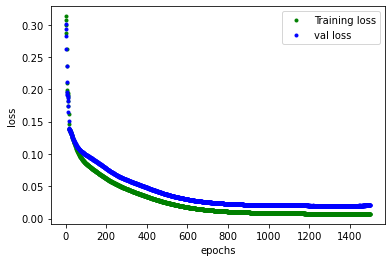

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'g.', label="Training loss")
plt.plot(epochs, val_loss, 'b.', label="val loss")

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#Run with Test Data
Put our test data into the model and plot the predictions

5/5 [==============================] - 0s 786us/step
predictions =
 [[0.014 0.    0.022 0.965 0.   ]
 [1.    0.    0.    0.    0.   ]
 [0.994 0.    0.    0.006 0.   ]
 [0.024 0.    0.029 0.947 0.   ]
 [0.    0.998 0.    0.    0.002]
 [0.    0.997 0.    0.    0.003]
 [0.    0.    0.957 0.003 0.04 ]
 [0.    0.995 0.    0.    0.005]
 [0.698 0.    0.219 0.015 0.067]
 [1.    0.    0.    0.    0.   ]
 [0.    0.    0.967 0.003 0.03 ]
 [0.    0.    0.967 0.003 0.031]
 [0.014 0.    0.022 0.964 0.   ]
 [0.005 0.    0.947 0.048 0.   ]
 [0.093 0.    0.    0.907 0.   ]
 [0.    0.    0.034 0.    0.966]
 [1.    0.    0.    0.    0.   ]
 [0.014 0.    0.022 0.964 0.   ]
 [0.    0.995 0.    0.    0.005]
 [0.003 0.    0.957 0.041 0.   ]
 [0.    0.997 0.    0.    0.003]
 [0.    0.    0.957 0.003 0.04 ]
 [0.    0.997 0.    0.    0.003]
 [0.    0.974 0.    0.    0.026]
 [0.    0.998 0.    0.    0.002]
 [0.014 0.    0.022 0.965 0.   ]
 [1.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.   ]
 [0.996 

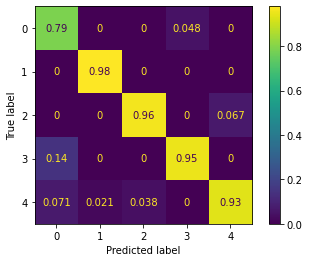

In [8]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# sns.regplot(outputs_test, predictions)
#Predict
y_prediction = np.argmax(predictions, axis = 1)

y_test=np.argmax(outputs_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
disp =  ConfusionMatrixDisplay(confusion_matrix=result)
print(result)
disp.plot()
# Plot the predictions along with to the test data
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
# plt.plot(inputs_test, predictions, 'r.', label='Predicted')
# plt.show()

In [9]:
array_test = [[33., 0.152, 0.83, 27., 18.]]
pred_test = model.predict(array_test)

print(pred_test)
class_index = np.argmax(pred_test)
print(class_index)
print(CLASSES[class_index])

1/1 [==============================] - 0s 23ms/step
[[9.9989247e-01 1.4909005e-20 1.2927471e-13 1.0756188e-04 5.0500826e-27]]
0
laptop


In [10]:
model.save('model_saved/')

INFO:tensorflow:Assets written to: model_saved/assets
